In [1]:
from mne import read_epochs, set_eeg_reference, compute_rank
from mne.decoding import CSP, UnsupervisedSpatialFilter
from mne.preprocessing import ICA, EOGRegression
import numpy as np
from mne.viz import plot_ica_components
from jupyterthemes.stylefx import set_nb_theme
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
set_nb_theme('gruvboxd')

Load and Preprocessing

In [2]:
import sys
sys.path.append('../../preprocessing')
from load_data import load_raw_to_epochs, get_channel_types

# load_raw_to_epochs('eva.bdf', True)

In [3]:
raw = read_epochs('raw_epo.fif')

Reading C:\Users\Alberto\Documents\BCI\data\eva\raw_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
raw.copy().filter(1,120, n_jobs=4).plot(n_channels=20, n_epochs=3, scalings=30e-6, events=epochs.events, event_id=epochs.event_id)

Marking bad chanels

In [4]:
bads = ['AF7','P8','FT7', 'P1','T8', 'FC4', 'EXG4', 'EXG5', 'EXG8', 'O2', 'PO3', 'FT8','TP7', 'P10', 'TP8', 'Iz', 'F4', 'Fp2', 'Fp1', 'FC6', 'C6', 'PO8']
raw.info['bads'] = bads
raw.drop([7, 8, 13, 16, 18, 31, 58, 64, 76])

Dropped 9 epochs: 7, 8, 13, 16, 18, 31, 58, 64, 76


<EpochsFIF |  70 events (all good), -2 - 7.99902 sec, baseline off, ~399.3 MB, data loaded,
 'r_pinch': 12
 'r_stop': 15
 'left': 16
 'right': 16
 'rest': 11>

Referencing

In [5]:
referenced = set_eeg_reference(raw, ref_channels='average')[0]
del raw

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Set channel types

In [6]:
referenced.set_channel_types(get_channel_types())

<EpochsFIF |  70 events (all good), -2 - 7.99902 sec, baseline off, ~399.3 MB, data loaded,
 'r_pinch': 12
 'r_stop': 15
 'left': 16
 'right': 16
 'rest': 11>

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 3068 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 4477 out of 4480 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 4480 out of 4480 | elapsed:    4.3s finished


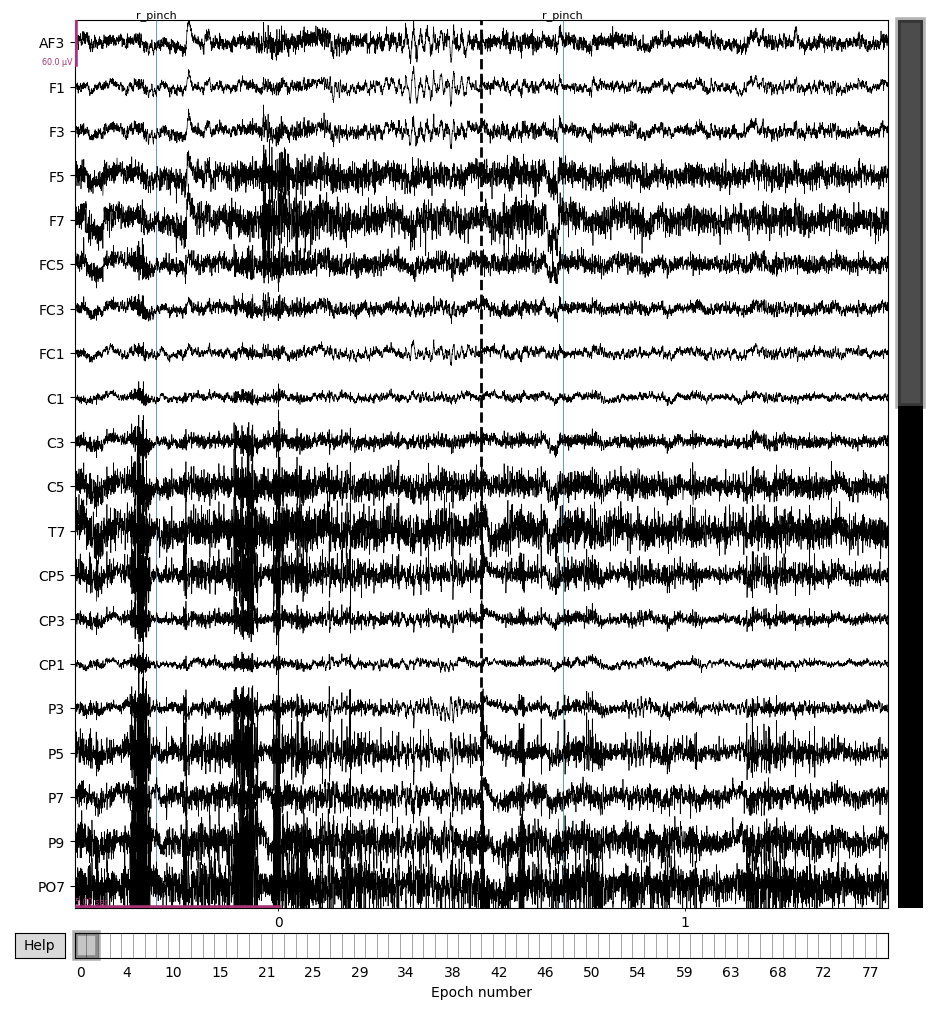

In [27]:
referenced.copy().filter(1,120, n_jobs=4).plot(n_channels=20, n_epochs=2, scalings=30e-6, events=referenced.events, event_id=referenced.event_id)
print()

EOG Regression

In [7]:
print()
emg_eog = ['EXG3','EXG4','EXG1','EXG2','EXG6','EXG7','Fpz','PO7','T8']
regressor = EOGRegression(
    picks='eeg', picks_artifact= emg_eog).fit(referenced)
# regressor.plot()
# referenced = regressor.apply(referenced)
referenced.info['bads'] += ['Fpz','PO7','T8']


No projector specified for this dataset. Please consider the method self.add_proj.


In [43]:
referenced.save('referenced_epo.fif', overwrite=True)
del referenced

Overwriting existing file.


REMOVE ARTIFACTS


In [8]:
epochs = read_epochs('referenced_epo.fif')
epochs

Reading C:\Users\Alberto\Documents\BCI\data\eva\referenced_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated


<EpochsFIF |  70 events (all good), -2 - 7.99902 sec, baseline off, ~399.3 MB, data loaded,
 'r_pinch': 12
 'r_stop': 15
 'left': 16
 'right': 16
 'rest': 11>


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


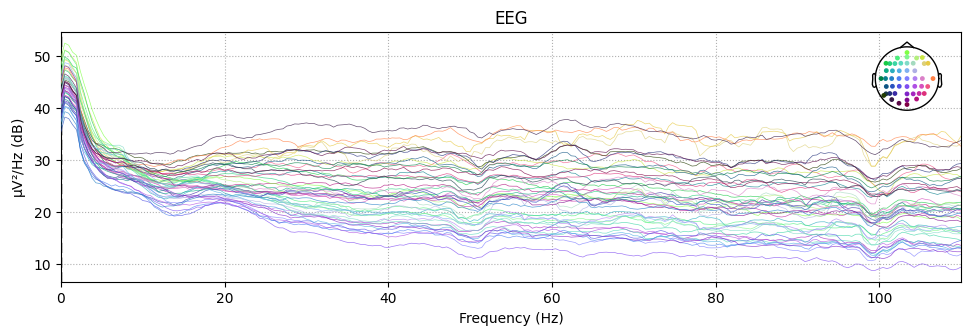

In [14]:
print()
epochs['right','left'].copy().crop(-1,2).plot_psd(fmax=110, tmin=-.1, tmax=2)

ICA

In [9]:
filtered = epochs.copy().filter(1,250, n_jobs=8)
filtered.apply_baseline((-1.4,-0.1))
filtered.crop(0,5)
ica = ICA(n_components=.9, method='picard')
ica.fit(filtered)

Setting up band-pass filter from 1 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 62.50 Hz (-6 dB cutoff frequency: 281.25 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:   11.4s
[Parallel(n_jobs=8)]: Done 347 tasks      | elapsed:   13.0s
[Parallel(n_jobs=8)]: Done 2896 tasks      | elapsed:   20.2s
[Parallel(n_jobs=8)]: Done 4448 tasks      | elapsed:   23.8s
[Parallel(n_jobs=8)]: Done 4480 out of 4480 | elapsed:   23.9s finished


Applying baseline correction (mode: mean)
Fitting ICA to data using 45 channels (please be patient, this may take a while)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_14112\3273349700.py:5: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(filtered)


Selecting by explained variance: 11 components
Fitting ICA took 34.1s.


<ICA | epochs decomposition, method: picard (fit in 80 iterations on 358470 samples), 11 ICA components (45 PCA components available), channel types: eeg, no sources marked for exclusion>

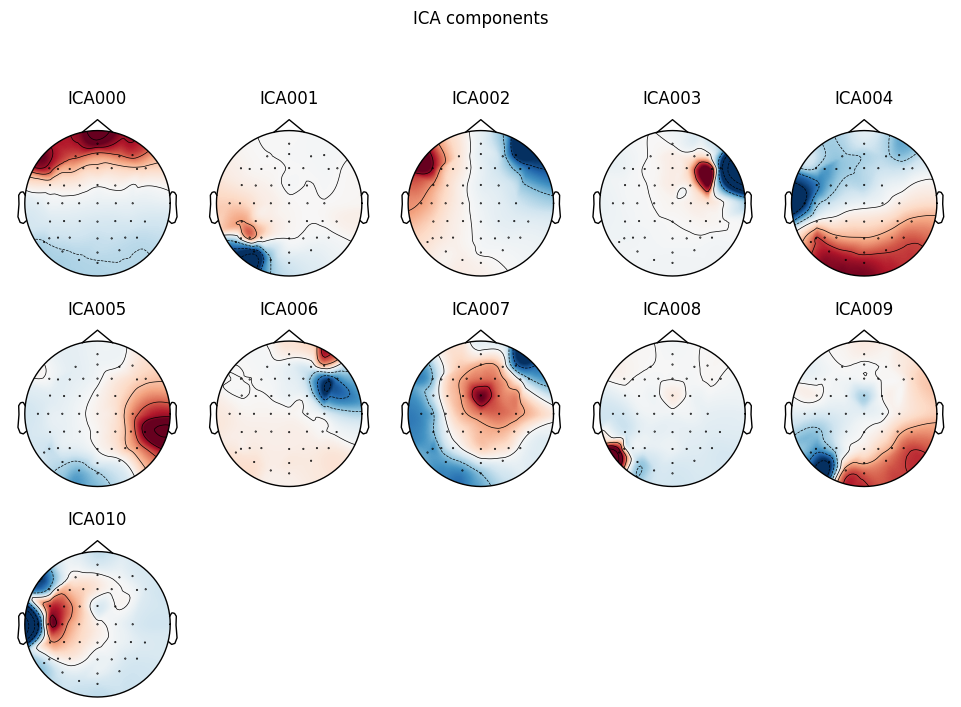

[<MNEFigure size 975x731.5 with 11 Axes>]

In [10]:
print()
plot_ica_components(ica)


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


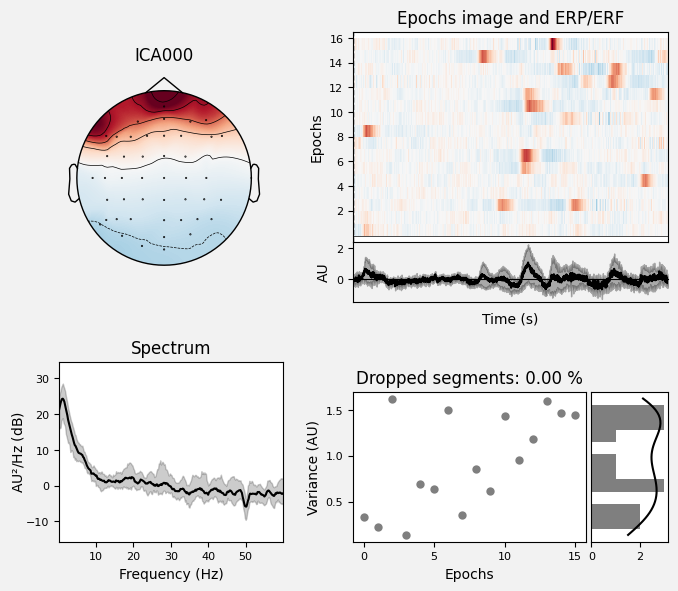

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


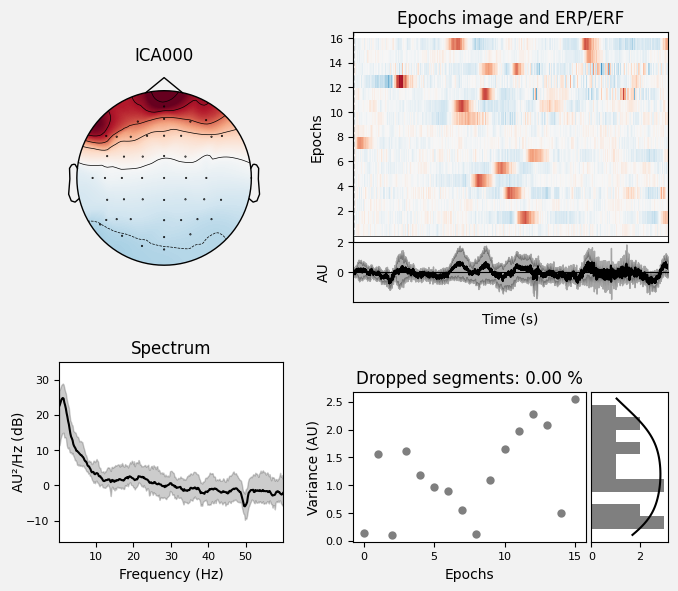

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


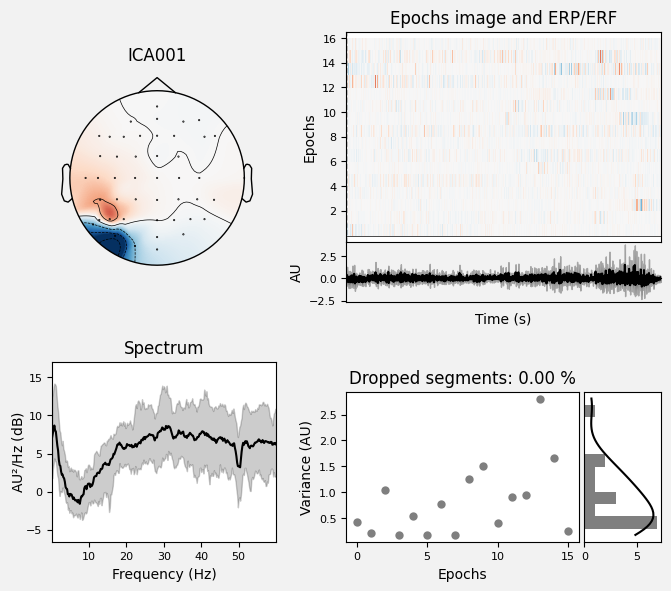

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


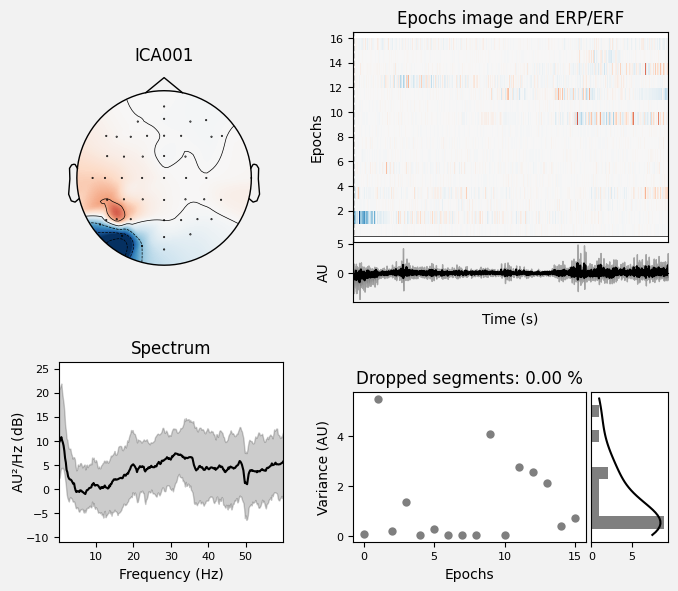

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


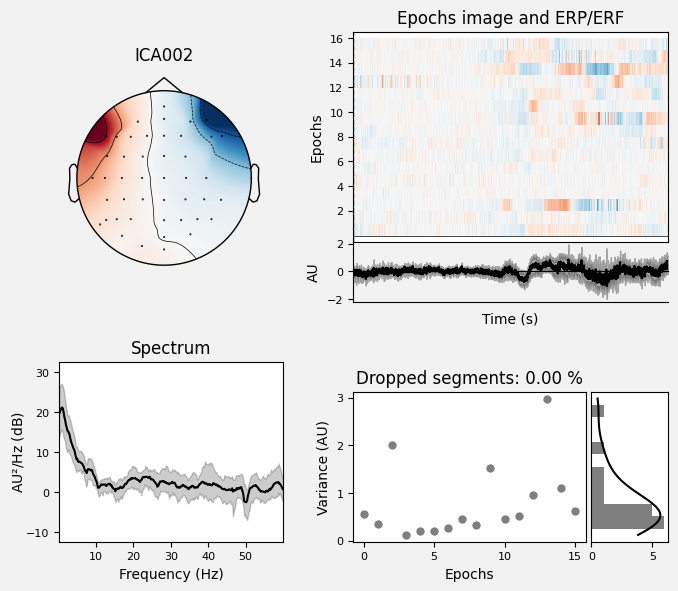

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


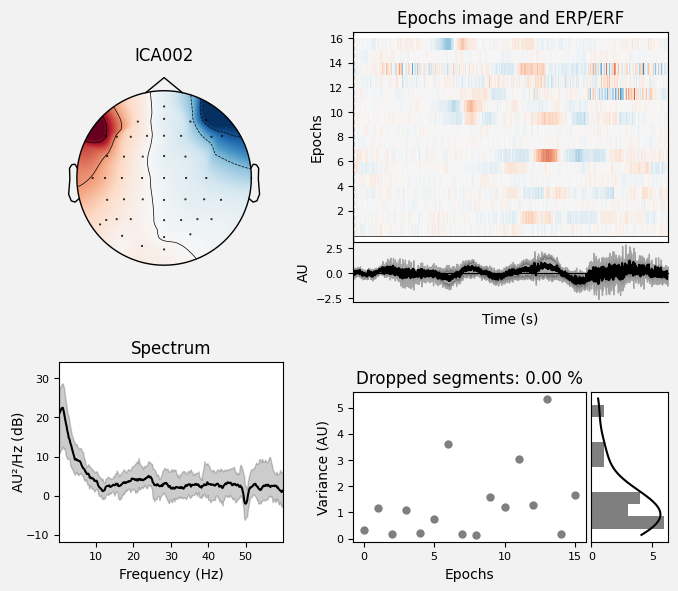

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


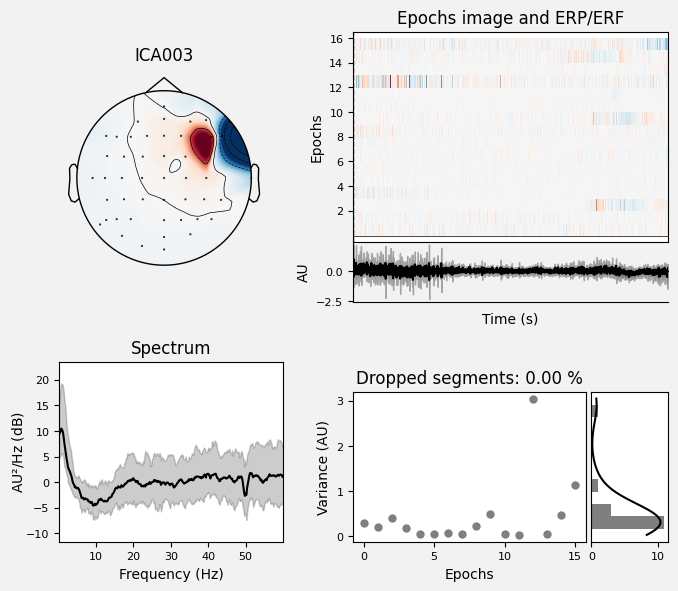

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


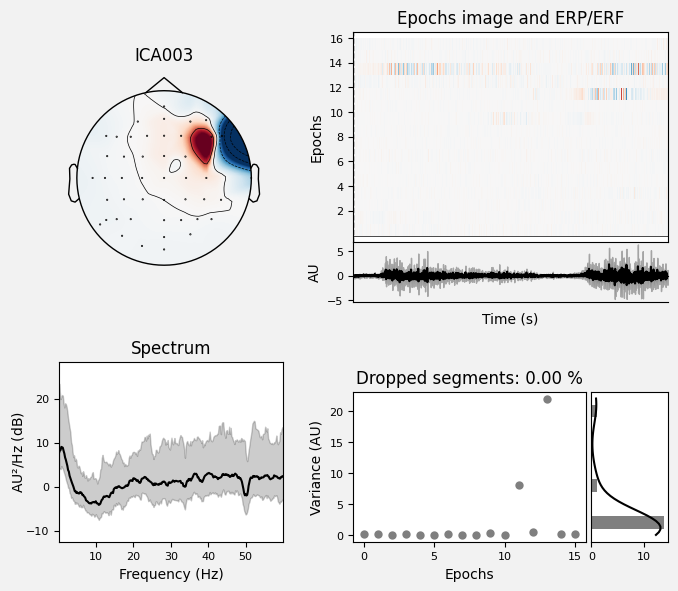

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


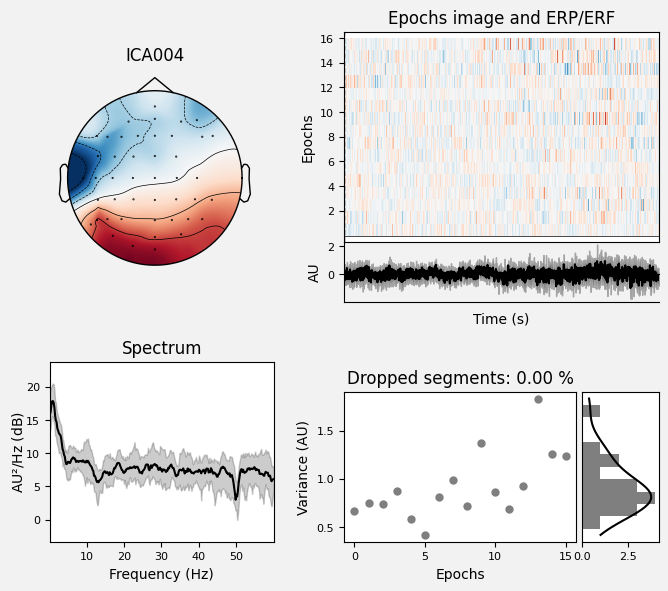

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


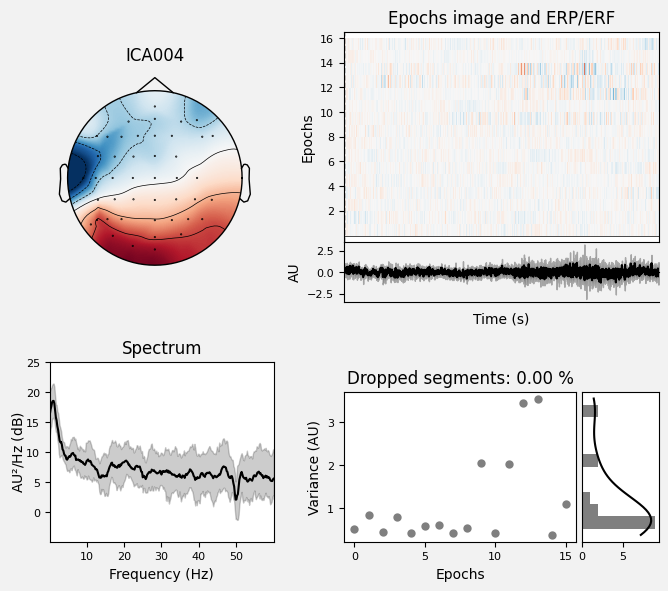

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


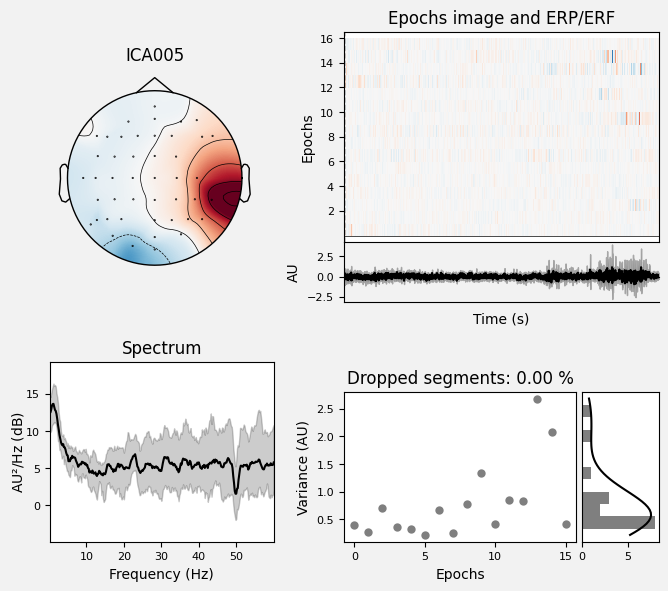

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


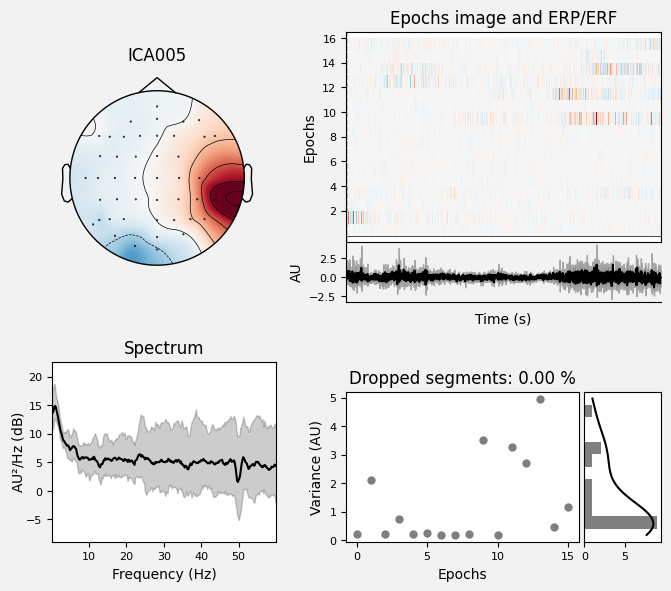

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


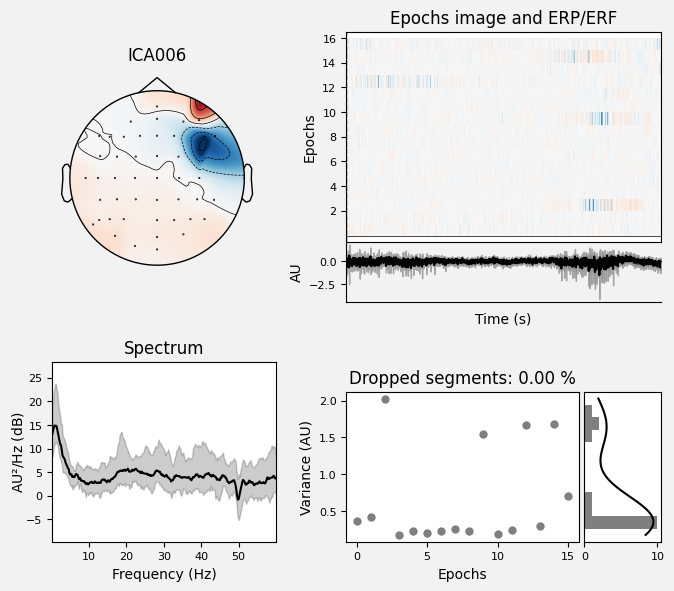

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


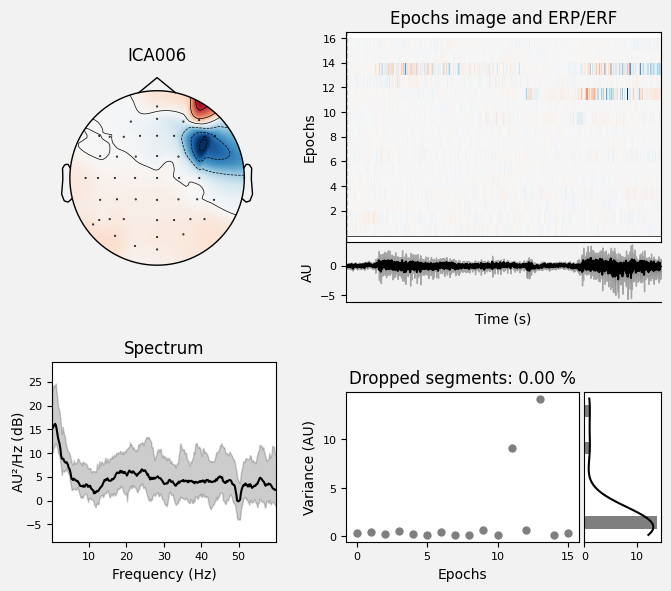

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


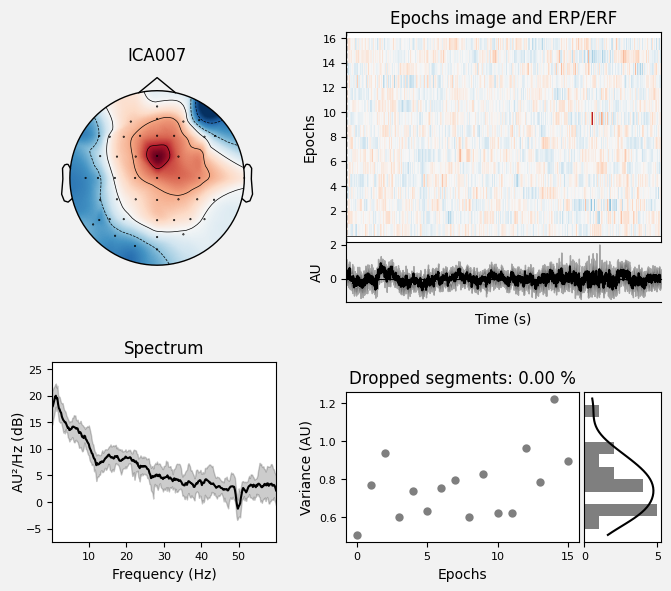

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


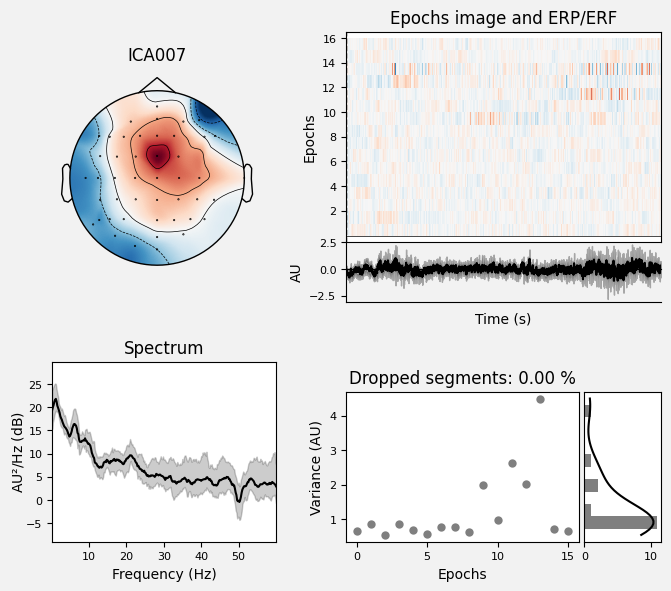

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


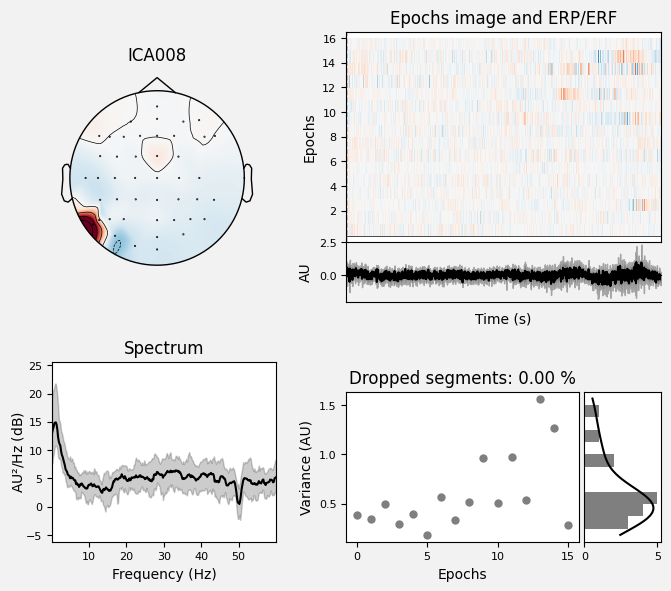

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


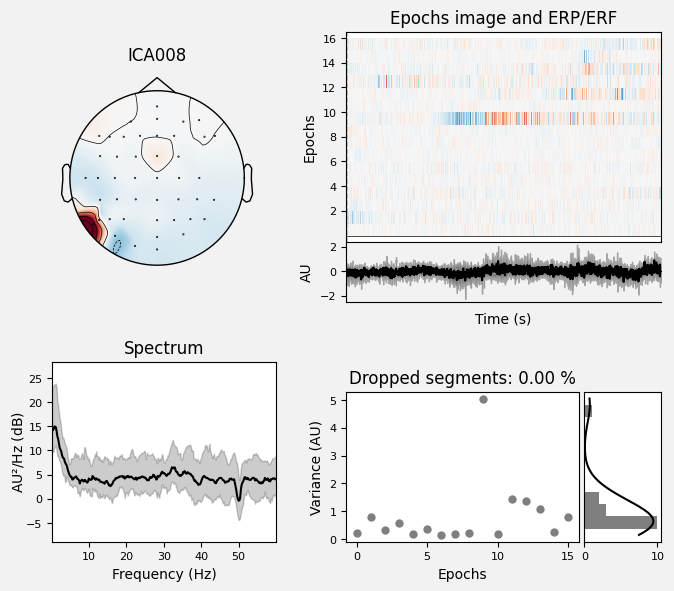

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


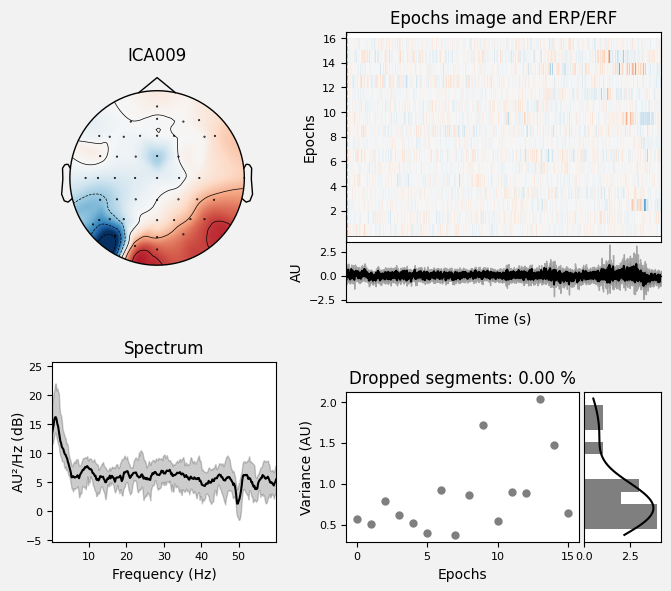

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


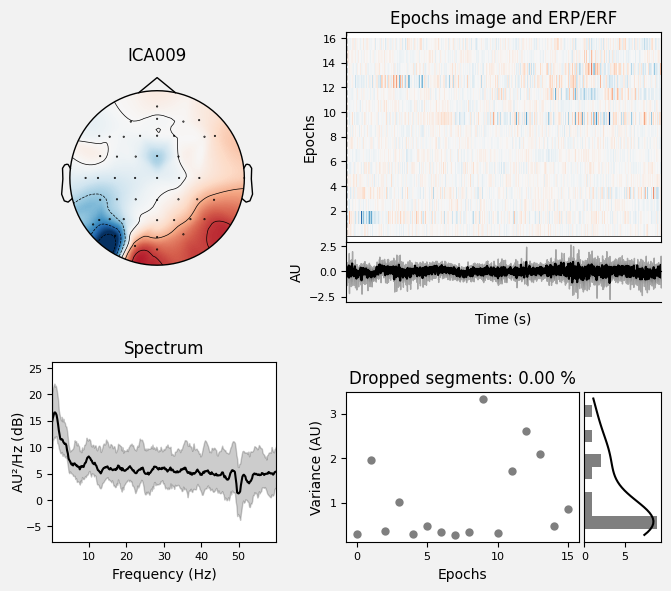

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


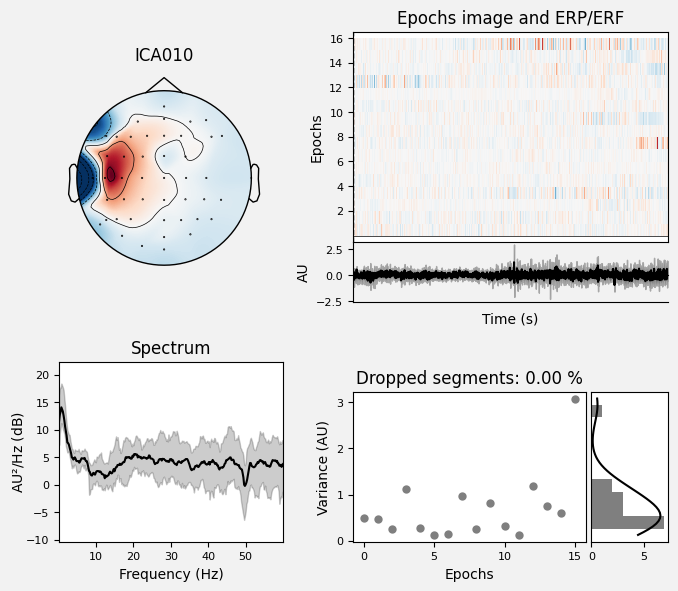

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


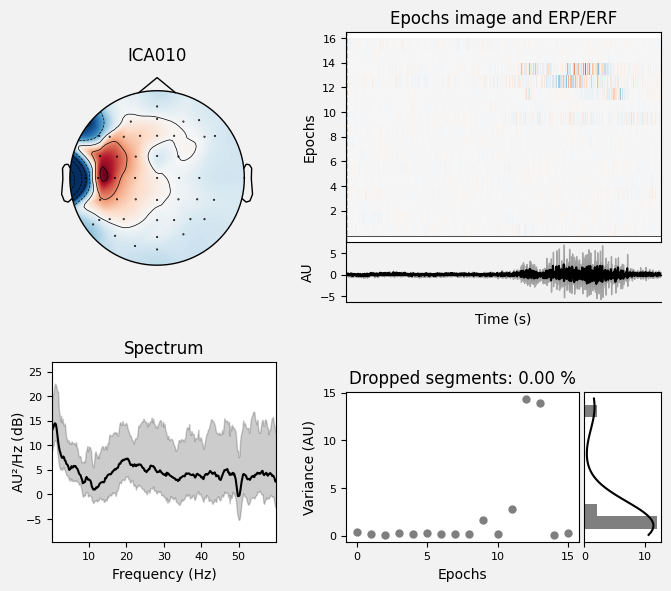

next


IndexError: index 11 is out of bounds for axis 1 with size 11

In [11]:
for i in np.arange(12):
    ica.plot_properties(
        epochs['left'].copy().crop(0,5).filter(1,240, verbose=False), 
        picks = [i], 
        log_scale = False,
        psd_args = dict(fmin=.1, fmax=60))

    ica.plot_properties(
        epochs['right'].copy().crop(0,5).filter(1,240, verbose=False), 
        picks = [i], 
        log_scale = False,
        psd_args = dict(fmin=.1, fmax=60))
    
    print('next')

In [12]:
ica.apply(epochs, exclude= [0,1,2,3,4,5,6,8,10])

Applying ICA to Epochs instance
    Transforming to ICA space (11 components)
    Zeroing out 9 ICA components
    Projecting back using 45 PCA components


<EpochsFIF |  70 events (all good), -2 - 7.99902 sec, baseline off, ~399.3 MB, data loaded,
 'r_pinch': 12
 'r_stop': 15
 'left': 16
 'right': 16
 'rest': 11>

ERP

Setting up band-pass filter from 1 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 62.50 Hz (-6 dB cutoff frequency: 281.25 Hz)
- Filter length: 3381 samples (3.302 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_14112\2041666621.py:1: RuntimeWarning: filter_length (3381) is longer than the signal (2561), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['left','right'].copy().crop(-0.5,2).filter(1,250, n_jobs=8).average().plot()
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1016 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 2006 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 2048 out of 2048 | elapsed:    2.5s finished


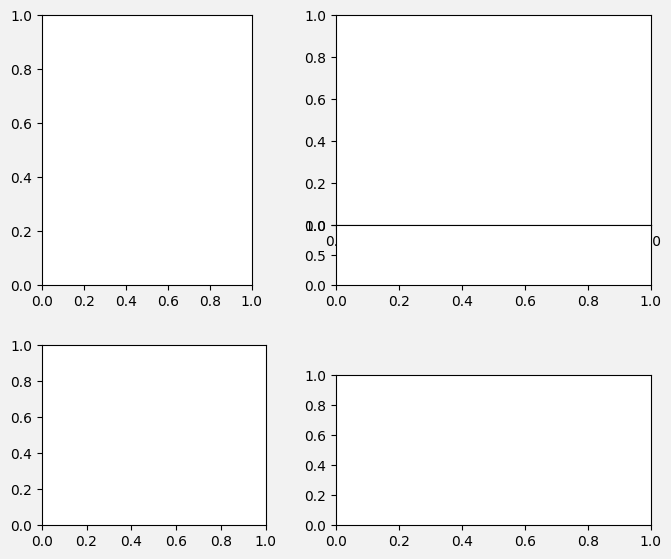

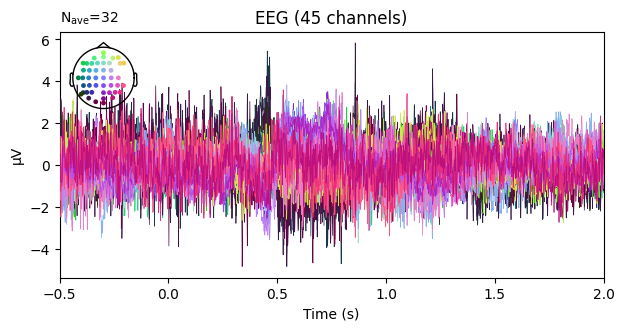

In [13]:
epochs['left','right'].copy().crop(-0.5,2).filter(1,250, n_jobs=8).average().plot()
print()

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_14112\2447180343.py:1: RuntimeWarning: filter_length (3381) is longer than the signal (2561), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['rest'].copy().crop(-0.5,2).filter(1,120, n_jobs=8).average().plot()
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 536 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 704 out of 704 | elapsed:    0.8s finished


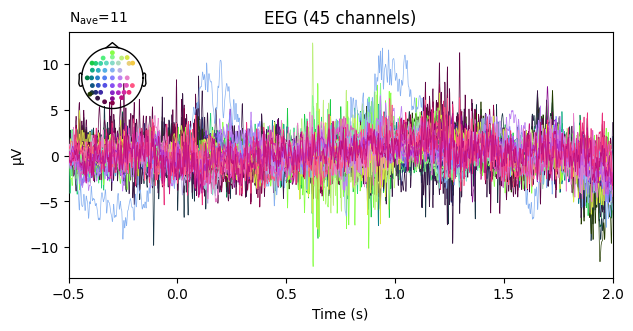

In [14]:
epochs['rest'].copy().crop(-0.5,2).filter(1,120, n_jobs=8).average().plot()
print()

CSP 

In [49]:
le = LabelEncoder()
subset = epochs['left','rest'].copy()
subset.apply_baseline((-1.,-0.1))
subset.drop_channels(epochs.info['bads'])
subset = subset.pick(['eeg'])
y = le.fit_transform(subset.events[:,2])

Applying baseline correction (mode: mean)


In [50]:
pca = UnsupervisedSpatialFilter(PCA(len(subset.info['chs'])), average=False)
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False, rank='info')
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)

Computing rank from data with rank='info'
    MAG: rank 45 after 0 projectors applied to 45 channels
Reducing data rank from 45 -> 45
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 45 after 0 projectors applied to 45 channels
Reducing data rank from 45 -> 45
Estimating covariance using EMPIRICAL
Done.


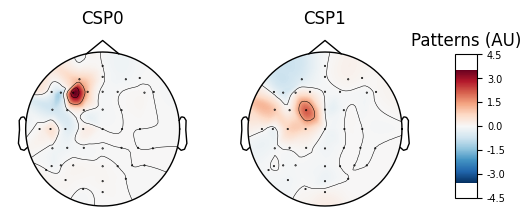

In [51]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 45 after 0 projectors applied to 45 channels
Reducing data rank from 45 -> 45
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 45 after 0 projectors applied to 45 channels
Reducing data rank from 45 -> 45
Estimating covariance using EMPIRICAL
Done.


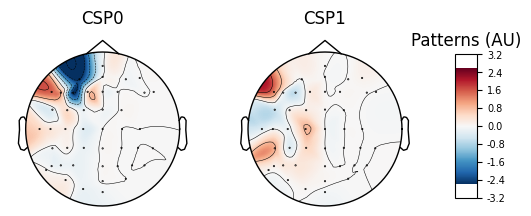

In [52]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(20, 35, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 43 after 0 projectors applied to 43 channels
Reducing data rank from 43 -> 43
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 43 after 0 projectors applied to 43 channels
Reducing data rank from 43 -> 43
Estimating covariance using EMPIRICAL
Done.


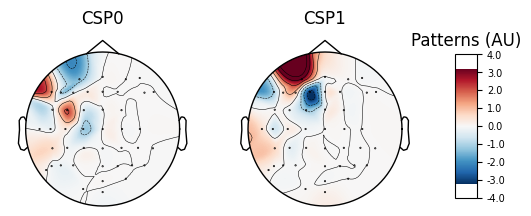

In [58]:
x = pca.fit_transform(subset.copy().crop(-0.1,1.8).filter(70, 90, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

In [15]:
epochs.save('ica_epo.fif', overwrite=True)

Overwriting existing file.
